### Differential Privacy - Stochastic Gradient Descent (DP-SGD)
[Kartikey Sharma](kartikey.sharma.5137@student.uu.se)   
2025-05-24

Python version: 3.13.2   
**Packages needed**
* PyTorch
* NumPy
* Pandas
* Matplotlib
* torchsummary
* torchvision
* opacus *for DP-SGD implementation*

**References**
* Module 4: 'Introduction to Differential Privacy' in the course
* Abadi et al. 2016 [Deep Learning with Differential Privacy](https://arxiv.org/pdf/1607.00133)

**Objectives**   
This notebook explains how differential privacy works in case of neural networks. We explore **Differentially private - Stochastic Gradient Descent** (DP-SGD) and its algorithm. We compare model's performance with and without DP.

In [1]:
## !pip install numpy
## !pip install pandas
## !pip install torch
## !pip install matplotlib
## !pip install torchsummary
## !pip install torchvision

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchsummary

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchvision.datasets import MNIST
from opacus.opacus.privacy_engine import PrivacyEngine
from torchvision.transforms import ToTensor

**vanilla model**

In [4]:
## import MNIST dataset
## create dataloader
train_dataset = MNIST(root='./', train = True, download=True, transform=ToTensor())
train_loader  = data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

Text(0.5, 1.0, 'Sample Image with label: 5')

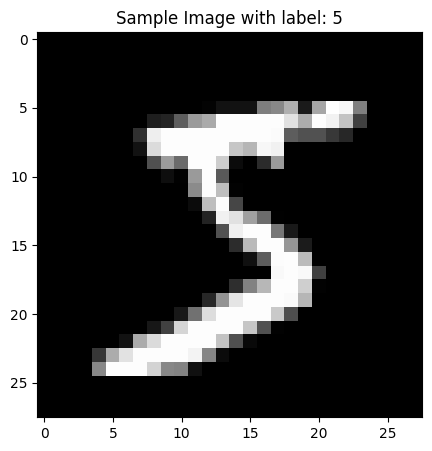

In [5]:
## visualize one sample image
sample = train_dataset.data[0]
labels = train_dataset.targets[0]

plt.figure(figsize=(5,5))
plt.imshow(sample, cmap='gray')
plt.title(f'Sample Image with label: {labels}')

In [6]:
## create model
## 2 CNN blocks
## 1 dense layer
class CNNModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), height=28, width=28, num_classes=10):
        super().__init__()
        self.block = nn.ModuleList()
        self.block.append(nn.Conv2d(in_channels,out_channels,kernel_size,padding=1))
        self.block.append(nn.ReLU())
        self.block.append(nn.LayerNorm([out_channels,height,width]))
        self.block.append(nn.MaxPool2d(kernel_size=(2,2), stride=2))
    
    def forward(self, x):
        for layer in self.block:
            x = layer(x)
        return x ## return output from 1 CNN block

class CNNNetwork(nn.Module):
    def __init__(self, in_channels, out_channels, dense_layers=[64], num_classes=10): ## cnn1-cnn2-linears
        super().__init__()
        self.cnn1 = CNNModule(in_channels[0], out_channels[0], height=28, width=28)
        self.cnn2 = CNNModule(in_channels[1], out_channels[1], height=14, width=14)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dense1 = nn.Linear(out_channels[1]*7*7, dense_layers[0])
        self.dense2 = nn.Linear(dense_layers[0], num_classes)
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x ## logits

In [ ]:
## hyperparameters
in_channels = [1,16]
out_channels = [16,32]
learning_rate = 0.001 ## for sgd
batch_size = 32
num_epochs = 5

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = CNNNetwork(in_channels, out_channels).to(device)
print(torchsummary.summary(model, input_size=(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         LayerNorm-3           [-1, 16, 28, 28]          25,088
         MaxPool2d-4           [-1, 16, 14, 14]               0
         CNNModule-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
              ReLU-7           [-1, 32, 14, 14]               0
         LayerNorm-8           [-1, 32, 14, 14]          12,544
         MaxPool2d-9             [-1, 32, 7, 7]               0
        CNNModule-10             [-1, 32, 7, 7]               0
          Flatten-11                 [-1, 1568]               0
           Linear-12                   [-1, 64]         100,416
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [10]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [11]:
valid_dataset = MNIST(root='./', train=False, download=True, transform=ToTensor())
valid_images = valid_dataset.data.unsqueeze(1).float() / 255.0 ## shape -1*1*28*28
valid_labels = valid_dataset.targets

train_images = train_dataset.data.unsqueeze(1).float() / 255.0 ## shape -1*1*28*28
train_labels = train_dataset.targets

In [12]:
## accumulators for loss and accuracy
tloss_acc = []
vloss_acc = []
vaccu_acc = []

In [13]:
## training // model performance computation and comparison
def train(model, train_loader, optimizer, num_epochs = 10):
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()  ## compute gradients
            optimizer.step() ## take the step

        ## validation
        model.eval()
        with torch.no_grad():
            images = train_images.to(device)
            labels = train_labels.to(device)
            logits = model(images)
            tloss = criterion(logits,labels)

            images = valid_images.to(device)
            labels = valid_labels.to(device)
            logits = model(images)
            vloss = criterion(logits,labels)
            predicted = torch.argmax(logits, dim=1)
            accuracy = (predicted == labels).float().mean().item()

        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train loss: {tloss.item():.4f} \t Test loss: {vloss.item():.4f} \t Acc%: {accuracy:.2f}%')
        vaccu_acc.append(accuracy)
        vloss_acc.append(vloss.item())
        tloss_acc.append(tloss.item())

    return tloss_acc, vloss_acc, vaccu_acc

In [14]:
def visualize(train_loss, valid_loss, valid_acc):
    
    fig, axes = plt.subplots(1,2,figsize=(12,5))
    axes[0].plot(train_loss, label='Train loss')
    axes[0].plot(valid_loss, label='Valid loss')
    axes[0].set_title('Loss vs Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(valid_acc, label='Valid accuracy%')
    axes[1].set_title('Accuracy% vs Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy%')
    axes[1].legend()

Epoch: 1/3
Train loss: 0.2173 	 Test loss: 0.2068 	 Acc%: 0.95%
Epoch: 2/3
Train loss: 0.1349 	 Test loss: 0.1274 	 Acc%: 0.96%
Epoch: 3/3
Train loss: 0.1025 	 Test loss: 0.0963 	 Acc%: 0.97%


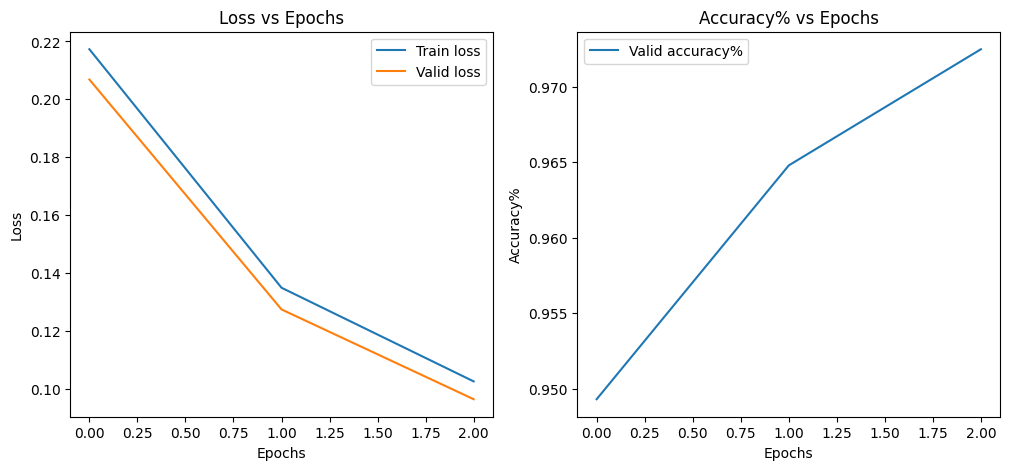

In [15]:
tloss_acc, vloss_acc, vaccu_acc = train(model, train_loader, optimizer, num_epochs=num_epochs) ##training
visualize(tloss_acc, vloss_acc, vaccu_acc)

**Introduction**   
When training Machine learning models, we try to learn from the training dataset. And it is possible that models can memorize certain patterns (or Features) from the data. It is possible that sensitive information can be extracted from model weights. The idea is to apply differentially private mechanism during model training (on computed gradients).   

**Logic**   
The post-processing property states that arbitrary computations on a differentially private output does not change $\epsilon$ (privacy budget). And so once we ensure the gradients are dp then so is the resulting model. The privacy is added to numerical values i.e., gradients by sampling i.i.d random value from a **gaussian distribution**, and then adding to the deterministic output. We call this random value **noise**. So now, how much noise should be added? It depends on the largest gradient of the sample in a mini-batch. This sample (maybe an outlier or a completely new sample) is most at the risk of exposure.

**Algorithm**   
we compute per-sample gradient, clip them using bound on gradient C, average the gradients into batches and add gaussian noise to this aggregation. Then we take a step is the opposite direction of the noisy gradient. The Gaussian distribution depends on C and noise multiplier (Standard deviation $\sigma$). Following is the code implementation for this.

```
for epoch in range(num_epochs):
    aggregate = dict()
    for name, param in model.named_parameters(): ## accumulate per-sample gradients
        aggregate[name] = []

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            
            image = image.to(device)
            label = label.to(device)
            logit = model(image)
            loss = criterion(logit, label)
            loss.backward() ## compute per-sample grad

            ## clip gradients and aggregate
            for name,param in model.named_parameters():
                if param.grad is not None:
                    grad = param.grad.detach().clone()
                    l2_norm = torch.norm(grad,2)
                    grad = grad/max(1,l2_norm/C)
                    aggregate[name].append(grad)
        
        for name, param in model.named_parameters(): # average accumulated gradient
            if param.grad is not None:
                param.grad = torch.mean(torch.stack(aggregate[name], dim=0), dim=0)
                noise = torch.randn(param.grad.shape).to(device)*noise_multiplier*C
                param.grad = param.grad + noise
                optimizer.step() ## update step
                optimizer.zero_grad()
```

The above implementation gave **CUDA: out of memory** error. We use Opacus which is a PyTorch implementation for differentially-private SGD [Link](https://opacus.ai/). It is faster as it consider matrix computations.

In [16]:
dp_model  = CNNNetwork(in_channels, out_channels).to(device) ## Differentially private model
optimizer = optim.SGD(dp_model.parameters(), lr=learning_rate, momentum=0.5)

In [17]:
## Hyperparameters for DP-SGD
C = 4.0 ## max gradient norms
noise_multiplier = 2.0

privacy_engine = PrivacyEngine()
dp_model, optimizer, train_loader = privacy_engine.make_private(module=dp_model, data_loader=train_loader,
            optimizer=optimizer, noise_multiplier=noise_multiplier, max_grad_norm=C)

c:\Users\Lenovo\Desktop\Project\opacus\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch: 1/3
Train loss: 1.0415 	 Test loss: 1.0302 	 Acc%: 0.75%
Epoch: 2/3
Train loss: 0.4962 	 Test loss: 0.4835 	 Acc%: 0.87%
Epoch: 3/3
Train loss: 0.3330 	 Test loss: 0.3214 	 Acc%: 0.91%


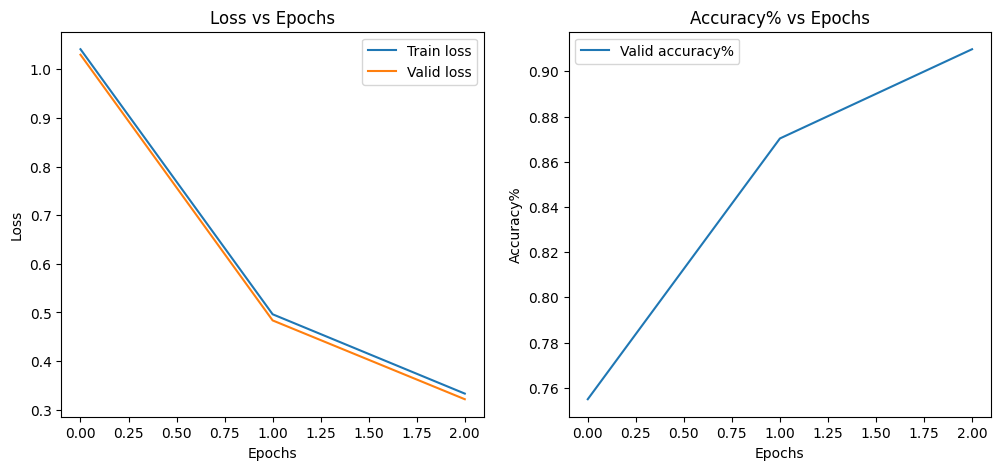

In [18]:
tloss_acc = []
vloss_acc = []
vaccu_acc = []

tloss_acc, vloss_acc, vaccu_acc = train(dp_model,train_loader,optimizer,num_epochs=num_epochs) ##training
visualize(tloss_acc, vloss_acc, vaccu_acc)

It can be observed that the accuracy for differentially private model is < than vanilla model. Accuracy for DP model is around 91%.

---